[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Mannheim_Multihalle.ipynb)

In [ ]:
!pip install JaxSSO
!pip install nlopt

In [2]:
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
import JaxSSO.optimization as optimization
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import json

/tmp/ipykernel_3162830/3059525336.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#Import the geometry, mesh and fixed node info
f = open('Envelope.json')
 
# returns JSON object as 
# a dictionary
data = json.load(f)
f.close()

df = data['faces'] #Connectivity matrix
faces = np.array(df) #convert to numpy array
df2 = data['vertices'] #Coordinate
crd = np.array(df2) #convert to numpy array
df3 = data['vertex_is_red'] #Connectivity matrix
fixed_nodes = np.where(df3)[0] #convert to numpy array

#From faces to frames
import trimesh
mesh = trimesh.load('Envelope.ply')

cnct  = np.array(mesh.edges_unique)

In [4]:
#Normalize the coordinates
x_nodes = crd[:,0]-min(crd[:,0])
y_nodes = crd[:,1]-min(crd[:,1])
z_nodes = crd[:,2]

n_node = crd.shape[0] #number of nodes
n_ele = cnct.shape[0] #number of elements

In [5]:
design_nodes = [] 
for i in range(n_node):
  #if i not in fixed_nodes:
    design_nodes.append(i)

fixed_nodes = np.array(fixed_nodes,dtype=int)
design_nodes = np.array(design_nodes,dtype=int)
non_design_nodes = fixed_nodes
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]

design_crds = np.expand_dims(design_nodes,axis=1)
design_crds = np.hstack((design_crds,2*np.ones((design_crds.shape[0],1),dtype=int)))

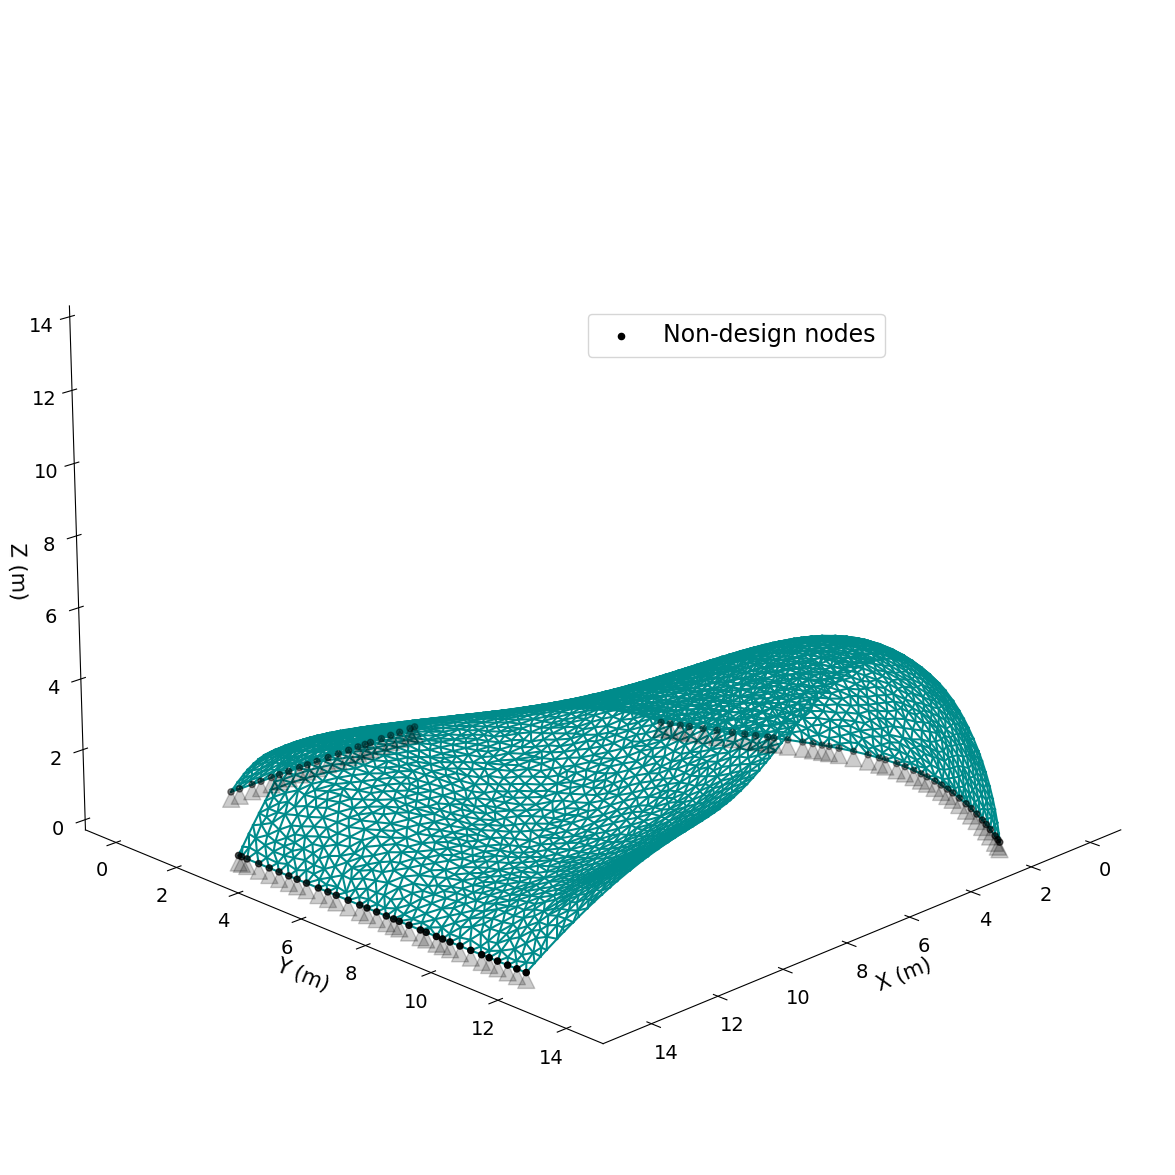

In [6]:

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,14)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, 45)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

In [7]:
# Inputs of NN
# Embed some info
# 1. X,Y COORDINATES
# 2. Distance to the boundary: how close they are to the boundary
# 3. Centrality
from jax import vmap
def dis_boundary(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the minimum distance of each node to the boundary node
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    return jnp.min(vmap_norm(crd_xy,bound_xy),axis=1)

def v_centrality(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the vertex centrality. Normalized so that maximum is "1".
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    
    return jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1)/jnp.max(jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1))

In [8]:
dis_b = dis_boundary(x_nodes,y_nodes,non_design_nodes)[design_nodes]
v_cen = v_centrality(x_nodes,y_nodes,non_design_nodes)[design_nodes]

In [9]:
################
#  SSO MODEL   #
################
#Build the model
#Sectional properties-> 600x400 rectangle
h = 0.2 #height
b = 0.1 #width
E = 37900 * 10**2 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = b*h**3/12 #Moement of inertia in m^4
Iz = h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area
load = -100000/1000 #Pt load

model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):

    model.add_node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i in fixed_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    model.add_beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) 


In [10]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [11]:
%timeit sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)

1.24 s ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
import pymesh
from flax import linen as nn

In [13]:
class SimpleNN(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons
    num_layers: int #Number of hidden layers

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        for i in range(self.num_layers):
            x = nn.Dense(features=self.num_hidden)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

In [14]:
n_input = 3 #(X,Y,dis_b,v_centrality) of each node
n_hidden = 500 # neurons
n_out = 1 #Z of each node
n_layers =3 #number of hidden layers

rng = jax.random.PRNGKey(42)

inp = np.array([x_nodes[design_nodes],y_nodes[design_nodes],dis_b]).T
#rng, inp_rng, init_rng = jax.random.split(rng, 3)

In [15]:
NN = SimpleNN(n_hidden,n_out,n_layers)

In [16]:
import jax
import jax.numpy as jnp  # JAX NumPy


print(NN.tabulate(rng,inp,
                   compute_flops=True, compute_vjp_flops=True))


                                SimpleNN Summary                                
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┓
┃ path    ┃ module   ┃ inputs    ┃ outputs  ┃ flops     ┃ vjp_flo… ┃ params    ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━┩
│         │ SimpleNN │ float64[… │ float64… │ 27757985… │ 8323255… │           │
├─────────┼──────────┼───────────┼──────────┼───────────┼──────────┼───────────┤
│ Dense_0 │ Dense    │ float64[… │ float64… │ 9648000   │ 27565500 │ bias:     │
│         │          │           │          │           │          │ float32[… │
│         │          │           │          │           │          │ kernel:   │
│         │          │           │          │           │          │ float32[… │
│         │          │           │          │           │          │           │
│         │          │           │          │           │          │ 2,000     │
│         │          │     

In [17]:
rng, init_rng = jax.random.split(rng, 2)
# Initialize the model
params = NN.init(init_rng, inp)

In [18]:
NN.apply(params,inp).reshape(-1).shape

(2756,)

In [19]:
import optax
optimizer = optax.adamw(learning_rate=0.0001,weight_decay=1e-4)

In [20]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=NN.apply,
                                            params=params,
                                            tx=optimizer)

In [21]:
def calculate_loss(state, params, inp):
    
    ##Apply_fn: ML input to output
    z_new = state.apply_fn(params, inp).reshape(-1) #Z-coordinate, ML-Output
    
    #ML output to loss through Jax-SSO
    sso_model.update_nodeparameter(z_new)
    loss = sso_model.params_to_objective()
     
    return loss#+jnp.norm(z_new)

In [22]:
@jax.jit  # Jit the function for efficiency
def train_step(state, inp):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, inp)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [23]:
%timeit train_step(model_state, inp)

1.2 s ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
metrics_history = {'train_loss': []}
from tqdm import tqdm
def train_model(state, num_epochs=2000):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        state, loss = train_step(state, inp)
        metrics_history['train_loss'].append(loss)
        print('Train epoch {}'.format(len(metrics_history['train_loss'])+1)+'  ,loss:{}'.format(loss))
        # We could use the loss and accuracy for logging here, e.g. in TensorBoard
        # For simplicity, we skip this part here
    return state

In [25]:
trained_model_state = train_model(model_state, num_epochs=50)

  2%|▏         | 1/50 [00:01<00:59,  1.21s/it]

Train epoch 2  ,loss:1297392.5585281248


  4%|▍         | 2/50 [00:02<00:58,  1.22s/it]

Train epoch 3  ,loss:528964.2644232227


  6%|▌         | 3/50 [00:03<00:57,  1.22s/it]

Train epoch 4  ,loss:305318.99393938377


  8%|▊         | 4/50 [00:04<00:55,  1.22s/it]

Train epoch 5  ,loss:217283.30723273207


 10%|█         | 5/50 [00:06<00:54,  1.21s/it]

Train epoch 6  ,loss:175836.5178150604


 12%|█▏        | 6/50 [00:07<00:53,  1.21s/it]

Train epoch 7  ,loss:148363.39152183023


 14%|█▍        | 7/50 [00:08<00:52,  1.21s/it]

Train epoch 8  ,loss:132230.34782320177


 16%|█▌        | 8/50 [00:09<00:50,  1.21s/it]

Train epoch 9  ,loss:119725.07181691163


 18%|█▊        | 9/50 [00:10<00:49,  1.21s/it]

Train epoch 10  ,loss:109148.93096008828


 20%|██        | 10/50 [00:12<00:48,  1.21s/it]

Train epoch 11  ,loss:99649.56370317764


 22%|██▏       | 11/50 [00:13<00:46,  1.20s/it]

Train epoch 12  ,loss:90785.74423866016


 24%|██▍       | 12/50 [00:14<00:45,  1.20s/it]

Train epoch 13  ,loss:82806.90302838176


 26%|██▌       | 13/50 [00:15<00:44,  1.20s/it]

Train epoch 14  ,loss:75476.49072411226


 28%|██▊       | 14/50 [00:16<00:43,  1.20s/it]

Train epoch 15  ,loss:68454.50444166549


 30%|███       | 15/50 [00:18<00:41,  1.20s/it]

Train epoch 16  ,loss:62267.76849211694


 32%|███▏      | 16/50 [00:19<00:41,  1.21s/it]

Train epoch 17  ,loss:57013.545828008064


 34%|███▍      | 17/50 [00:20<00:39,  1.21s/it]

Train epoch 18  ,loss:52717.5518278113


 36%|███▌      | 18/50 [00:21<00:38,  1.20s/it]

Train epoch 19  ,loss:49061.95155274578


 38%|███▊      | 19/50 [00:22<00:37,  1.20s/it]

Train epoch 20  ,loss:45981.00678841831


 40%|████      | 20/50 [00:24<00:36,  1.20s/it]

Train epoch 21  ,loss:43371.54025027493


 42%|████▏     | 21/50 [00:25<00:34,  1.20s/it]

Train epoch 22  ,loss:41111.10780116024


 44%|████▍     | 22/50 [00:26<00:33,  1.20s/it]

Train epoch 23  ,loss:39282.89403931586


 46%|████▌     | 23/50 [00:27<00:32,  1.20s/it]

Train epoch 24  ,loss:37841.16338922053


 48%|████▊     | 24/50 [00:28<00:31,  1.20s/it]

Train epoch 25  ,loss:36712.73503481489


 50%|█████     | 25/50 [00:30<00:29,  1.20s/it]

Train epoch 26  ,loss:35851.361824180254


 52%|█████▏    | 26/50 [00:31<00:28,  1.20s/it]

Train epoch 27  ,loss:35188.65406458586


 54%|█████▍    | 27/50 [00:32<00:27,  1.20s/it]

Train epoch 28  ,loss:34630.01005521095


 56%|█████▌    | 28/50 [00:33<00:26,  1.20s/it]

Train epoch 29  ,loss:34098.34306236417


 58%|█████▊    | 29/50 [00:34<00:25,  1.20s/it]

Train epoch 30  ,loss:33599.45217082027


 60%|██████    | 30/50 [00:36<00:24,  1.20s/it]

Train epoch 31  ,loss:33079.33094542088


 62%|██████▏   | 31/50 [00:37<00:22,  1.20s/it]

Train epoch 32  ,loss:32490.88280384032


 64%|██████▍   | 32/50 [00:38<00:21,  1.20s/it]

Train epoch 33  ,loss:31862.431347051406


 66%|██████▌   | 33/50 [00:39<00:20,  1.20s/it]

Train epoch 34  ,loss:31225.28567100248


 68%|██████▊   | 34/50 [00:40<00:19,  1.20s/it]

Train epoch 35  ,loss:30590.69116815883


 70%|███████   | 35/50 [00:42<00:18,  1.20s/it]

Train epoch 36  ,loss:30053.933739831133


 72%|███████▏  | 36/50 [00:43<00:16,  1.20s/it]

Train epoch 37  ,loss:29566.518653937943


 74%|███████▍  | 37/50 [00:44<00:15,  1.20s/it]

Train epoch 38  ,loss:29123.037889850108


 76%|███████▌  | 38/50 [00:45<00:14,  1.20s/it]

Train epoch 39  ,loss:28729.442337680273


 78%|███████▊  | 39/50 [00:46<00:13,  1.20s/it]

Train epoch 40  ,loss:28383.435461523266


 80%|████████  | 40/50 [00:48<00:11,  1.20s/it]

Train epoch 41  ,loss:28075.51175031004


 82%|████████▏ | 41/50 [00:49<00:10,  1.21s/it]

Train epoch 42  ,loss:27808.82147929226


 84%|████████▍ | 42/50 [00:50<00:09,  1.21s/it]

Train epoch 43  ,loss:27580.945132430992


 86%|████████▌ | 43/50 [00:51<00:08,  1.21s/it]

Train epoch 44  ,loss:27379.861843857878


 88%|████████▊ | 44/50 [00:52<00:07,  1.20s/it]

Train epoch 45  ,loss:27198.45303048938


 90%|█████████ | 45/50 [00:54<00:06,  1.20s/it]

Train epoch 46  ,loss:27022.97241751975


 92%|█████████▏| 46/50 [00:55<00:04,  1.20s/it]

Train epoch 47  ,loss:26852.45468479024


 94%|█████████▍| 47/50 [00:56<00:03,  1.20s/it]

Train epoch 48  ,loss:26680.243555907895


 96%|█████████▌| 48/50 [00:57<00:02,  1.20s/it]

Train epoch 49  ,loss:26501.864435471864


 98%|█████████▊| 49/50 [00:58<00:01,  1.20s/it]

Train epoch 50  ,loss:26322.17701930942


100%|██████████| 50/50 [01:00<00:00,  1.20s/it]

Train epoch 51  ,loss:26146.287434049424


In [28]:
##Apply_fn: ML input to output
z_new = trained_model_state.apply_fn(trained_model_state.params, inp).reshape(-1) #how to move nodes along z, ML-Outpu

#ML output to loss through Jax-SSO
z_nodes[design_nodes] = (z_new-np.min(z_new))

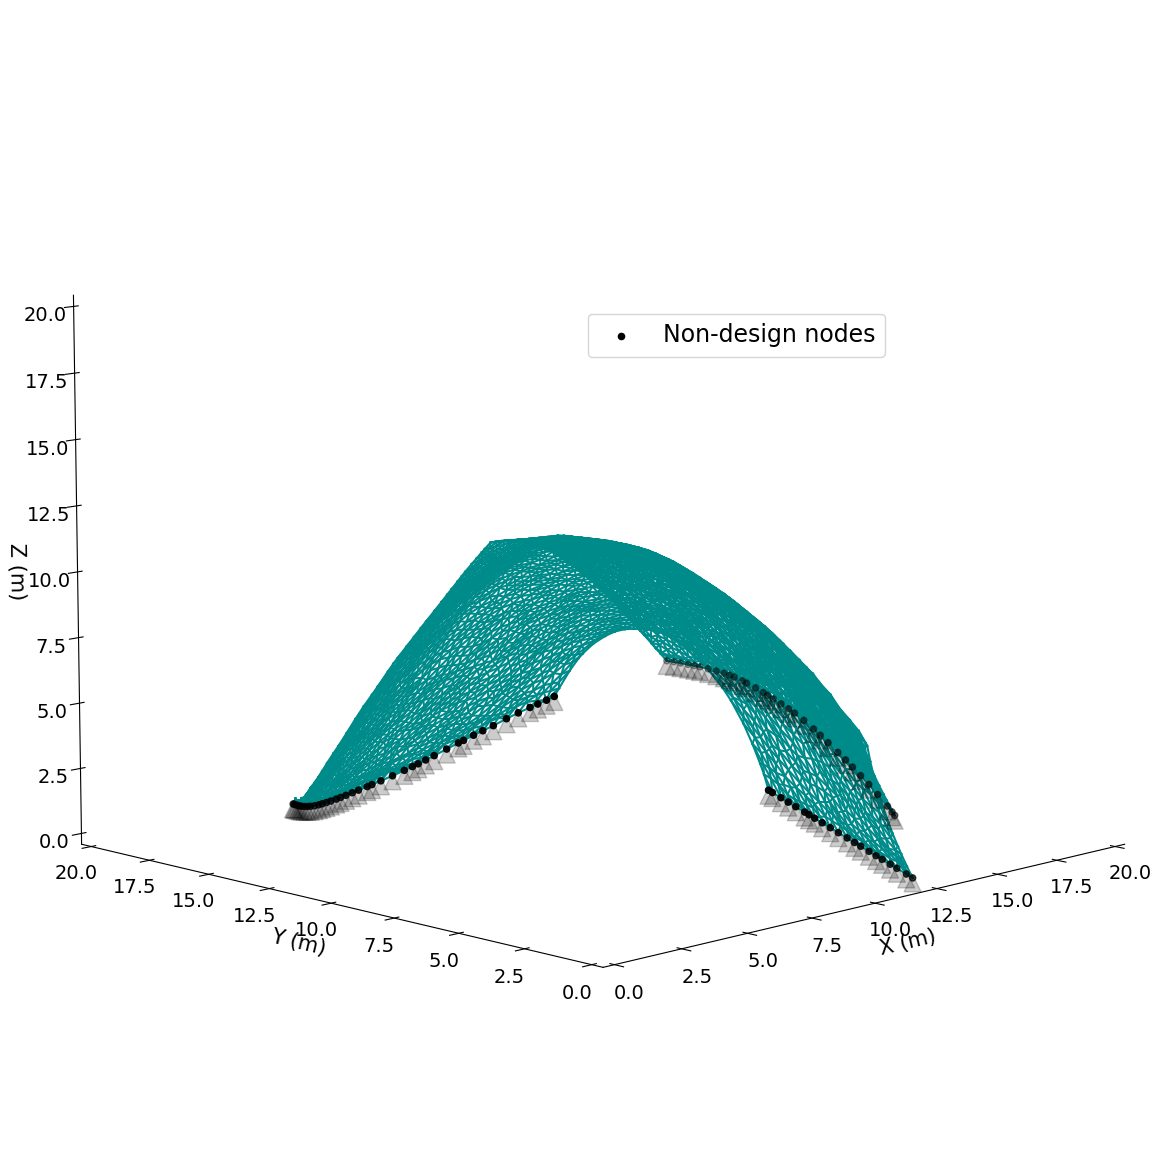

In [39]:
#Update the nodes
%matplotlib inline
z_ele[:,0] = z_nodes[cnct[:,0]]
z_ele[:,1] = z_nodes[cnct[:,1]]


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,20)
ax.set_xlim(0,20)
ax.set_ylim(0,20)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(10, -135)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()